In [90]:
from transformers import AutoModelForTokenClassification

# Will load LayoutLMv3ForTokenClassification
MODEL_PATH = "C:/Projects/IDP/watercare/model_output/23_10_30/best"
model = AutoModelForTokenClassification.from_pretrained(MODEL_PATH)

In [91]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained(MODEL_PATH, apply_ocr=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [133]:
# Load in image
from PIL import Image
import numpy as np
from pathlib import Path

# Open an image file
IMAGE_PATH = Path("C:/Projects/IDP/watercare/dataset/images/15-1.png")
image = Image.open(IMAGE_PATH)

# Convert the image to a NumPy array
image_array = np.array(image)
img_width, img_height = image.size

In [134]:
import pytesseract
from idp.annotations.bbox_utils import normalize_box

def get_text_box_pairs(image):
    tesseract_output = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
    boxes = []
    texts = []
    for i, level_idx in enumerate(tesseract_output["level"]):
        if level_idx == 5:
            bbox = [tesseract_output["left"][i],
                    tesseract_output["top"][i],
                    tesseract_output["left"][i]+tesseract_output["width"][i],
                    tesseract_output["top"][i]+tesseract_output["height"][i]
            ]
            if not tesseract_output["text"][i].strip():
                continue
            bbox = normalize_box(bbox, img_width, img_height)
            texts.append(tesseract_output["text"][i])
            boxes.append(bbox)

    return (texts, boxes)

texts, boxes = get_text_box_pairs(image)

In [135]:
# import csv

# with open('testFile.csv','w') as file:
#     for key in tesseract_output.keys():
#          file.write("%s, %s\n" % (key, tesseract_output[key]))

In [136]:
from pathlib import Path
import re

def is_box_a_within_box_b(box_a, box_b):
    left_a, top_a, right_a, bottom_a = box_a
    left_b, top_b, right_b, bottom_b = box_b
    
    # Check if Box B contains box A
    return left_b<=left_a and top_b<=top_a and right_b>=right_a and bottom_b>=bottom_a
    
# HACK remove texts & boxes outside of Labelling area
image_name = IMAGE_PATH.name
def text_box_relevant(text_box_pairs):
    text, box = text_box_pairs
    if re.search(r'\d-1.(png|jpg)$', image_name) != None:
        outer_box = normalize_box((623,640,1555,1698), img_width, img_height)
        return is_box_a_within_box_b(box, outer_box)
    elif re.search(r'\d-2.(png|jpg)$', image_name) != None:
        outer_box = normalize_box((192,170,1245,1778), img_width, img_height)
        return is_box_a_within_box_b(box, outer_box)
    else:
        return False
    
filtered_list = list(filter(text_box_relevant, list(zip(texts,boxes))))
result = [[text for text, box in filtered_list],[box for text, box in filtered_list]]
texts, boxes = result

In [137]:
encoding = processor(images=[image_array], text=texts, boxes=boxes, return_tensors="pt")

In [138]:
# HACK - Trim tokens to match 512 
# encoding['input_ids'] = encoding['input_ids'][:,:512]
# encoding['attention_mask'] = encoding['attention_mask'][:,:512]
# encoding['bbox'] = encoding['bbox'][:,:512]

encoding

{'input_ids': tensor([[    0,   475, 22501, 10491,  2259,   733,  2812,  2154,  8476,  4597,
         13097,  6944,  3628, 16036,  1907, 17256, 14422,   445, 14491,  2394,
            68, 39103,     4,  4563,  3977, 28925,   829,    68,   321,     4,
           612, 26193,   202, 14395,    68, 39103,     4,  4563,  3977,   318,
            47,   682,   156,    10,  3207,     6,    24,    40,  2082,    15,
           110,   220,  1087,     4,  9149,  1103, 24551,    81, 24999,    13,
          1254,  3201,  4850,    68,  5659,     4,  6405, 41768, 24159,  4850,
            68,  7994,     4,  5606, 41768, 24159,  4460,    68,   321,     4,
           612, 26193,     9,   595,  1103,    68, 24543,     4,  3118,   404,
           595,  1103,   680,   379,   207, 14162,    35,    68,   753,     4,
          1092,  5480,  1280,   528,    68, 22619,     4,  1570,  3977,  5053,
          2394, 14907,    71,     5,   528,  1248,   189, 30163,    41,   942,
          4029,     9,    68,   398,  

In [139]:
import torch

with torch.no_grad():
  outputs = model(**encoding)

In [140]:
outputs

TokenClassifierOutput(loss=None, logits=tensor([[[ 0.5625,  0.0925,  0.1371,  ...,  0.0272, -0.0189,  0.0892],
         [ 7.9390, -0.4984, -0.9529,  ..., -0.7690, -1.1024, -1.1208],
         [ 7.9662, -0.4844, -0.9828,  ..., -0.7917, -1.1179, -1.1032],
         ...,
         [ 7.9284, -0.5358, -0.9934,  ..., -0.8436, -1.1250, -1.1103],
         [ 7.8644, -0.5244, -1.0114,  ..., -0.8197, -1.1005, -1.1003],
         [ 0.5475,  0.0902,  0.1336,  ...,  0.0348, -0.0109,  0.0902]]]), hidden_states=None, attentions=None)

In [141]:
logits = outputs.logits
logits.shape

torch.Size([1, 147, 10])

In [142]:
predictions = logits.argmax(-1).squeeze().tolist()

In [143]:
model.config.id2label

{0: 'B-OTHER',
 1: 'B-BALANCE_STILL_OWING',
 2: 'B-WATER_CONSUMPTION',
 3: 'B-WASTEWATER_CONSUMPTION',
 4: 'B-WASTEWATER_FIXED',
 5: 'B-BALANCE_CURRENT_CHARGES',
 6: 'B-TOTAL_DUE',
 7: 'B-WATER_CONSUMPTION_DETAILS',
 8: 'B-WASTEWATER_CONSUMPTION_DETAILS',
 9: 'B-WASTEWATER_FIXED_DETAILS'}

In [144]:
from idp.annotations.bbox_utils import unnormalize_box, merge_box_extremes
from idp.annotations.annotation_utils import Classes, CLASS_TO_LABEL_MAP


token_boxes = encoding.bbox.squeeze().tolist()

input_id_list = encoding['input_ids'].squeeze()
true_predictions = [model.config.id2label[pred] for pred in predictions]
true_boxes = [unnormalize_box(box, img_width, img_height) for box in token_boxes]
true_texts = [processor.tokenizer.decode([input_id_list[i]]) for i in list(range(len(predictions)))]
    
output_dict = {value: {'text':'','box':[]} for key,value in CLASS_TO_LABEL_MAP.items() if key != Classes.OTHER}
for key in output_dict.keys():
    output_dict[key]['text'] = ''.join([ text for text, prediction in zip(true_texts, true_predictions) if prediction == key])
    output_dict[key]['box'] = merge_box_extremes([box for box, prediction in zip(true_boxes, true_predictions) if prediction == key])
    
#trim empty outputs
item_not_empty = lambda item : len(item[1]['text']) != 0
output_dict = dict(filter(item_not_empty, output_dict.items()))
output_dict

{'B-BALANCE_STILL_OWING': {'text': ' $ 283.69 cr',
  'box': [1385, 928, 1509, 949]},
 'B-WATER_CONSUMPTION': {'text': ' $ 61.94', 'box': [1398, 1167, 1477, 1188]},
 'B-WASTEWATER_CONSUMPTION': {'text': ' $ 84.61',
  'box': [1398, 1195, 1474, 1216]},
 'B-WASTEWATER_FIXED': {'text': ' $ 0.00', 'box': [1411, 1220, 1477, 1244]},
 'B-BALANCE_CURRENT_CHARGES': {'text': ' $ 146.55',
  'box': [1385, 1249, 1477, 1270]},
 'B-TOTAL_DUE': {'text': ' $ 137.14 cr', 'box': [1385, 1457, 1509, 1478]}}

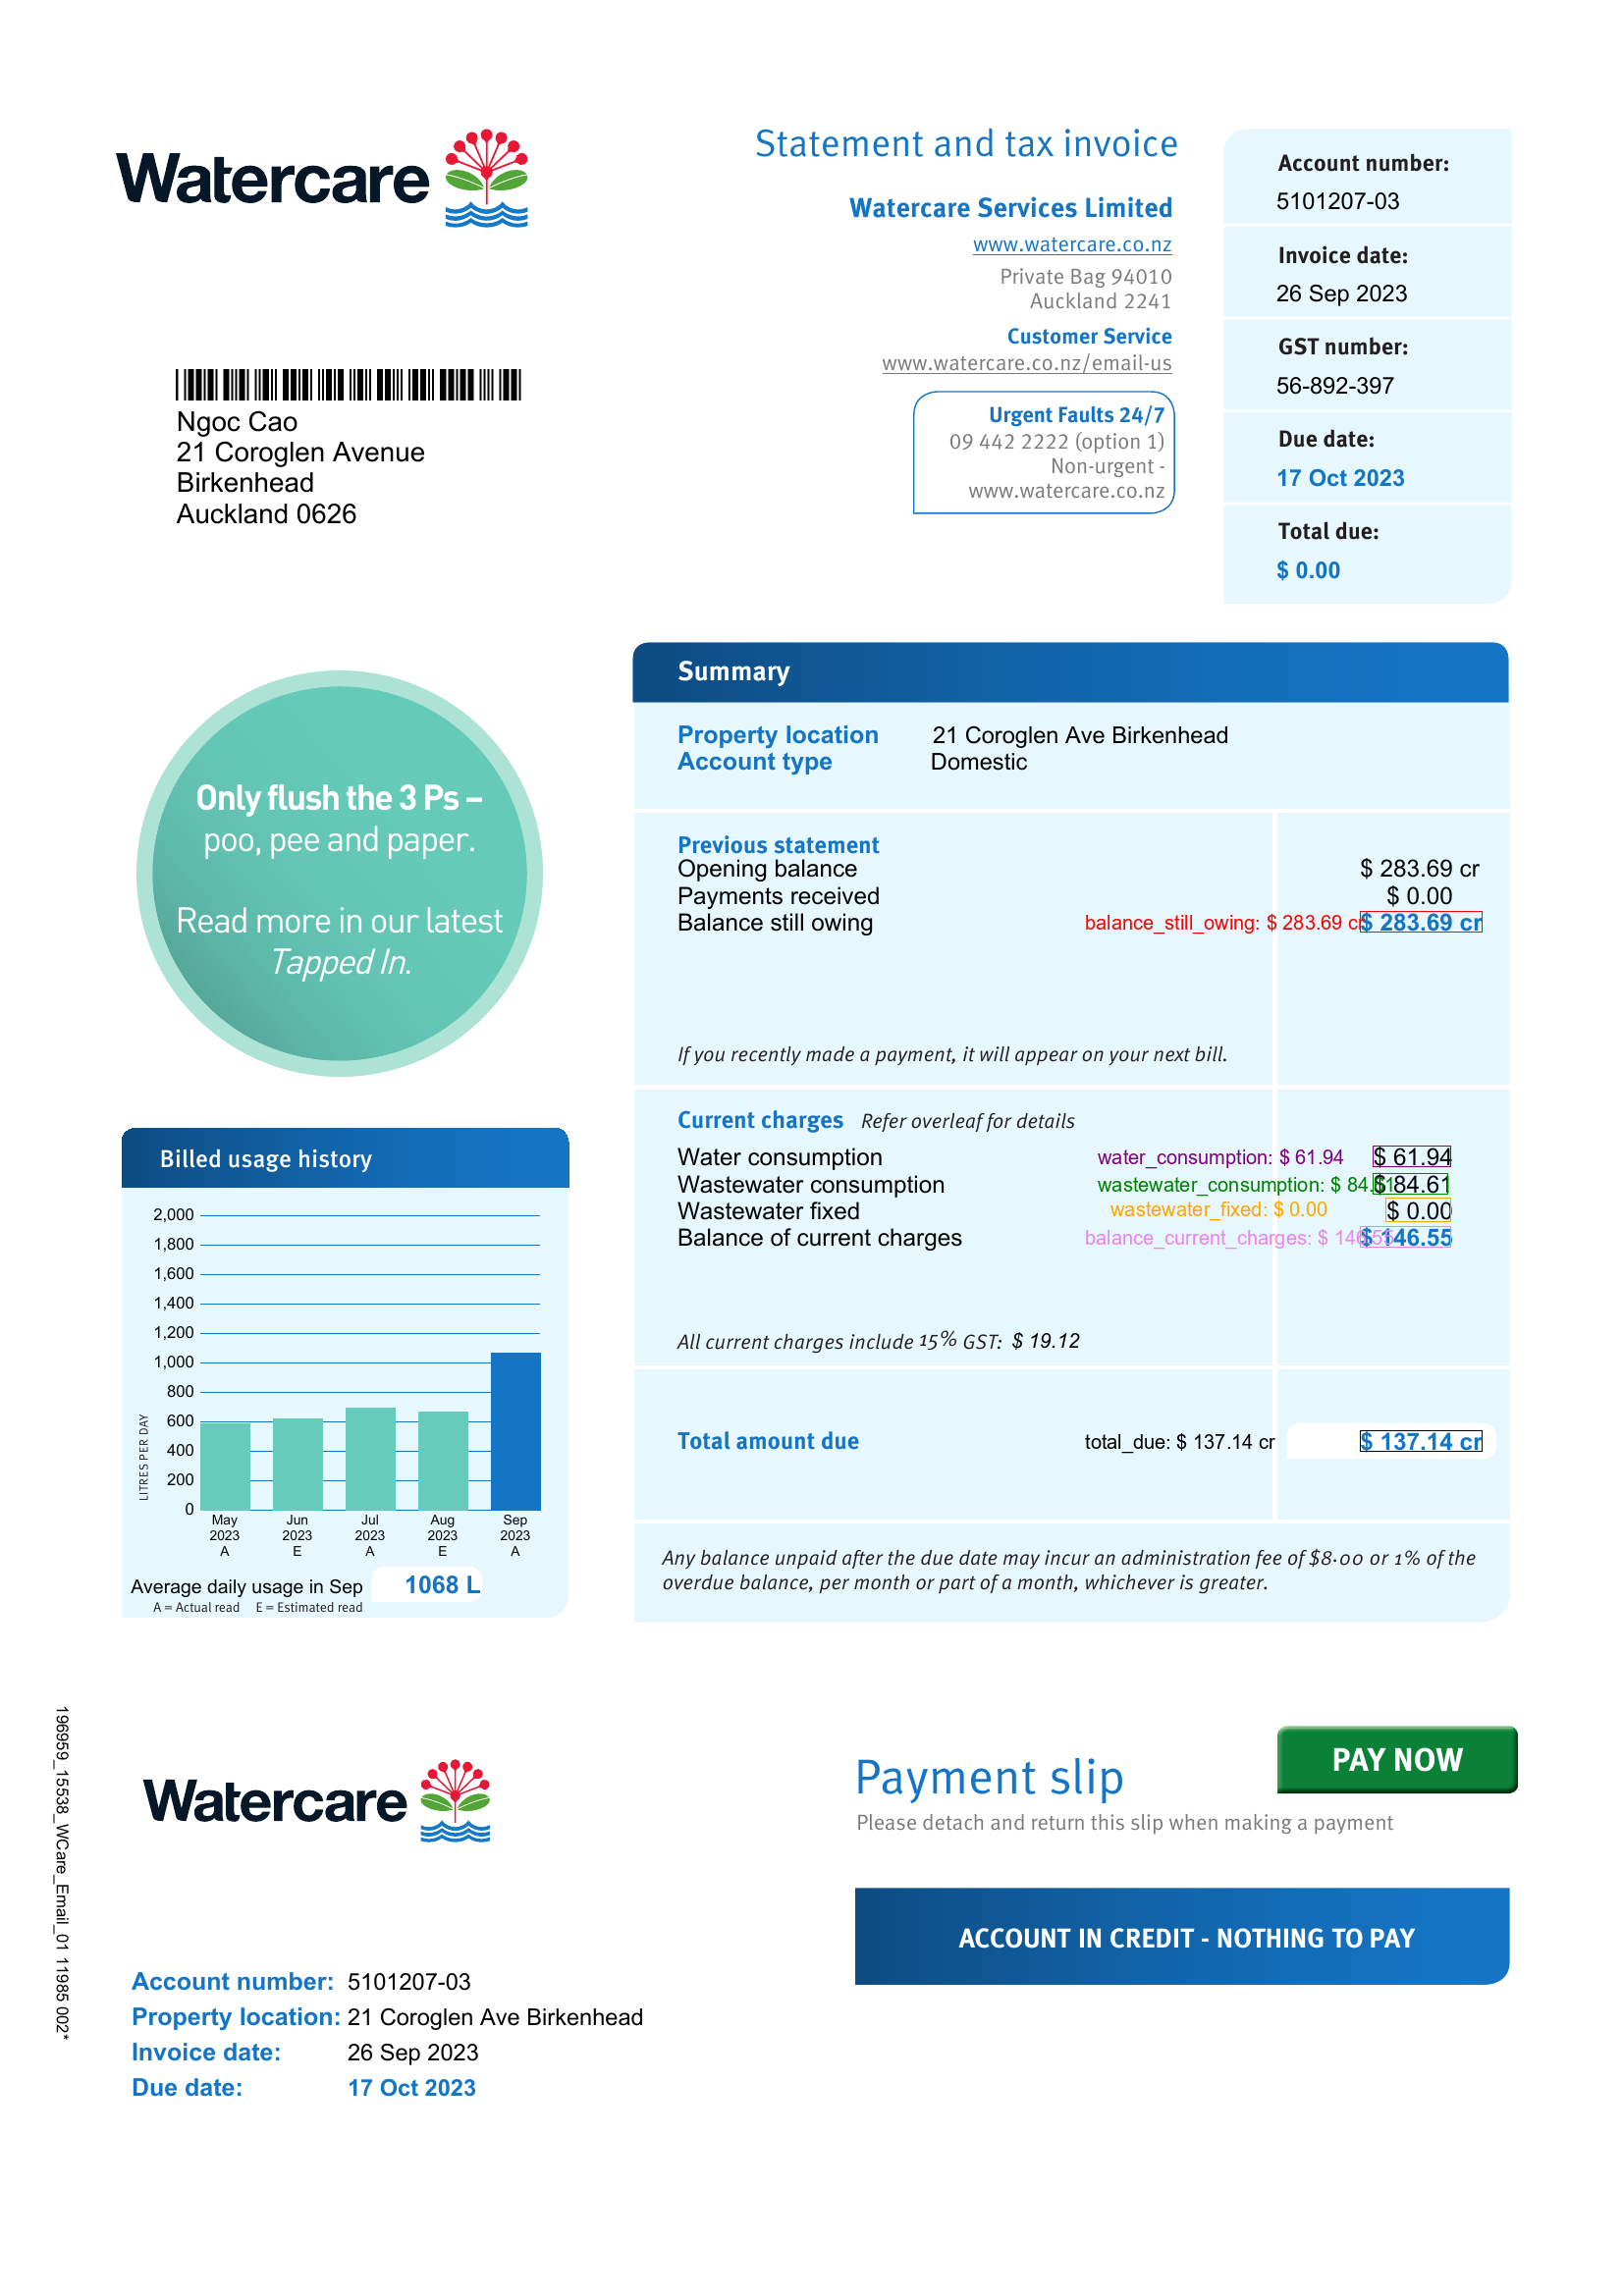

In [145]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

# font = ImageFont.load_default()
font = ImageFont.truetype("arial.ttf", 20)

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'other':'pink','balance_still_owing':'red', 'water_consumption':'purple', 'wastewater_consumption':'green', 'wastewater_fixed':'orange', 'balance_current_charges':'violet',
              "total_due": "black",'water_consumption_details':'red','wastewater_consumption_details':'purple','wastewater_fixed_details':'green','her':'black'}

# for prediction, box in zip(true_predictions, true_boxes):
#     predicted_label = iob_to_label(prediction).lower()
#     draw.rectangle(box, outline=label2color[predicted_label])
#     draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)
    
for item in output_dict.items():
    predicted_label = iob_to_label(item[0]).lower()
    box = item[1]['box']
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] - 280, box[1]), text=f"{predicted_label}:{item[1]['text']}", fill=label2color[predicted_label], font=font)
    
image